## Кошки и собаки: используем датасет

В этом ноутбуке мы рассмотрим, как обучить модель отличать кошек и собак на фотографии с использованием датасетов в DataSphere.

**ВАЖНО**: Мы предполагаем, что в директории `/home/jupyter/mnt/datasets/catsdogs/home/jupyter/mnt/datasets/catsdogs` смонтирован датасет с [Kaggle Cats and Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765https://www.microsoft.com/en-us/download/details.aspx?id=54765). Если это не так, и необходимо этот датасет создать - запустите ноутбук `create-dataset.ipynb`. Если же вы используете готовый датасет, то его надо будет добавить в проект и активировать.

Для начала загрузим необходимые библиотеки:

## Обучаем модель

Код ниже предполагает, что датасет смонтирован в директории `/home/jupyter/mnt/datasets/catsdogs`. Если если вы только что создали датасет, выполнив предыдущую ячейку - то так оно и будет.

Для начала импортируем необходимые библиотеки:

In [92]:
import os
# Отключаем лишние сообщения от Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras 

print(f"Версия Tensorflow: {tf.__version__}")

Версия Tensorflow: 2.12.0


Теперь загрузим датасет. Для этого будем использовать функцию `tf.keras.preprocessing.image_dataset_from_directorytf.keras.preprocessing.image_dataset_from_directory`. Сразу разобьем датасет на обучающую и валидационную (тестовую) выборки, и масштабируем изображения к размеру 224x224: 

In [79]:
path = '/home/jupyter/mnt/datasets/catsdogs/PetImages'

IMG_SIZE = 224

train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            path,
            shuffle=True,
            image_size=(IMG_SIZE,IMG_SIZE),
            validation_split=0.2,
            subset='both',
            seed=13)

classes = train_ds.class_names

Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Using 4953 files for validation.


Посмотрим, как выглядят изображения в датасете:

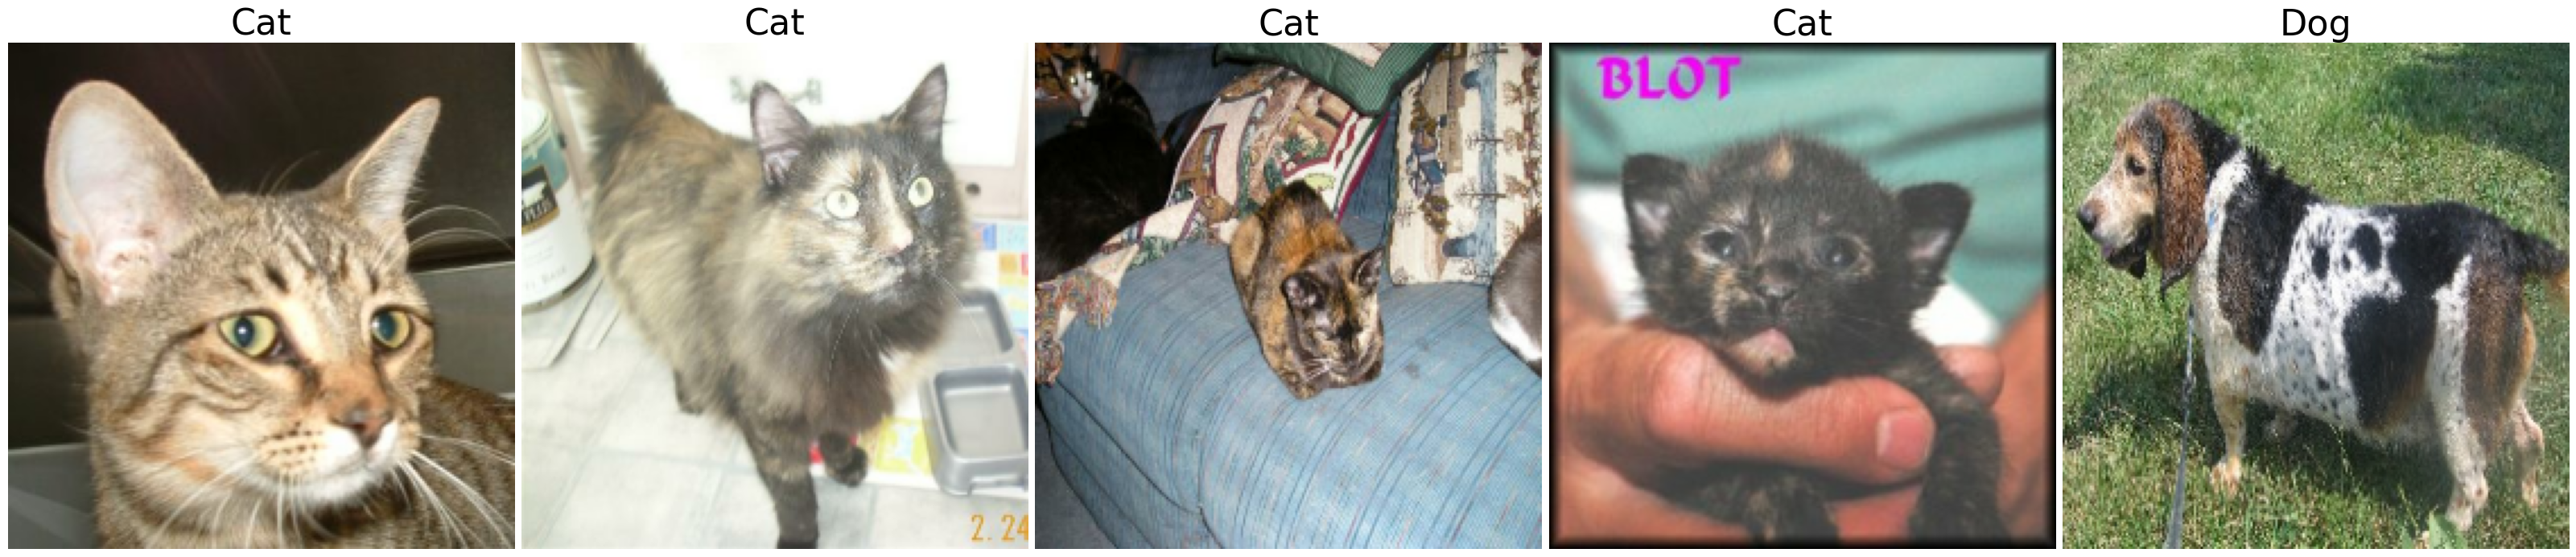

In [93]:
def display_images(l,titles=None,fontsize=32):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()
    
for x,y in train_ds:
    break

display_images(x[:5]/255.,titles=[classes[i] for i in y][:5])

Загрузим базовую модель - будем использовать ResNet50. Эту модель мы заморозим и будем использовать лишь как feature extractor.

In [94]:
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)
                            )
base_model.trainable = False

Oпишем нашу модель классификации:
* В качестве первого слоя используем функцию предобработки изображений `preprocess_input`, чтобы не вызывать её отдельно для всего датасета, а делать это внутри самой модели
* После применения базовой модели используем `Flatten` для превращения объемного тензора в вектор
* На последней слое используем один нейрон с функцией активации `sigmoid`

In [95]:
model = keras.Sequential([
    keras.layers.Lambda(lambda x : keras.applications.resnet_v2.preprocess_input(x)),
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Начинаем обучение модели:

In [96]:
EPOCHS = 3

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/3
 59/620 [=>............................] - ETA: 20s - loss: 0.4931 - acc: 0.9560

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


241/620 [==========>...................] - ETA: 14s - loss: 0.3929 - acc: 0.9737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/620 [============>.................] - ETA: 13s - loss: 0.3904 - acc: 0.9744

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


289/620 [============>.................] - ETA: 12s - loss: 0.3885 - acc: 0.9748

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


381/620 [=================>............] - ETA: 8s - loss: 0.3877 - acc: 0.9753

523/620 [========================>.....] - ETA: 3s - loss: 0.3684 - acc: 0.9781

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


543/620 [=========================>....] - ETA: 2s - loss: 0.3781 - acc: 0.9781

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


583/620 [===========================>..] - ETA: 1s - loss: 0.3818 - acc: 0.9783

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.3895 - acc: 0.9786

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 36s 48ms/step - loss: 0.3893 - acc: 0.9787 - val_loss: 0.4902 - val_acc: 0.9818
Epoch 2/3
 59/620 [=>............................] - ETA: 20s - loss: 0.1609 - acc: 0.9905

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


241/620 [==========>...................] - ETA: 14s - loss: 0.1740 - acc: 0.9912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/620 [============>.................] - ETA: 13s - loss: 0.1682 - acc: 0.9915

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


289/620 [============>.................] - ETA: 12s - loss: 0.1603 - acc: 0.9919

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


381/620 [=================>............] - ETA: 8s - loss: 0.1566 - acc: 0.9922

524/620 [========================>.....] - ETA: 3s - loss: 0.1528 - acc: 0.9924

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


542/620 [=========================>....] - ETA: 2s - loss: 0.1512 - acc: 0.9924

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/620 [===========================>..] - ETA: 1s - loss: 0.1486 - acc: 0.9925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.1478 - acc: 0.9926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 29s 46ms/step - loss: 0.1478 - acc: 0.9926 - val_loss: 0.5027 - val_acc: 0.9847
Epoch 3/3
 59/620 [=>............................] - ETA: 21s - loss: 0.0778 - acc: 0.9942

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


241/620 [==========>...................] - ETA: 14s - loss: 0.0689 - acc: 0.9953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


269/620 [============>.................] - ETA: 13s - loss: 0.0726 - acc: 0.9950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


289/620 [============>.................] - ETA: 12s - loss: 0.0761 - acc: 0.9948

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


381/620 [=================>............] - ETA: 8s - loss: 0.0713 - acc: 0.9951

523/620 [========================>.....] - ETA: 3s - loss: 0.0601 - acc: 0.9956

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


543/620 [=========================>....] - ETA: 2s - loss: 0.0585 - acc: 0.9956

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


583/620 [===========================>..] - ETA: 1s - loss: 0.0552 - acc: 0.9958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9959

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 29s 46ms/step - loss: 0.0535 - acc: 0.9959 - val_loss: 0.6961 - val_acc: 0.9830


Несмотря на то, что мы почистили датасет от испорченных файлов, всё равно Tensorflow не может открыть некоторые файлы, из-за чего возникают ошибки *Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9*.

Построим график изменения точности на обучающей и валидационной выборках в процессе обучения:

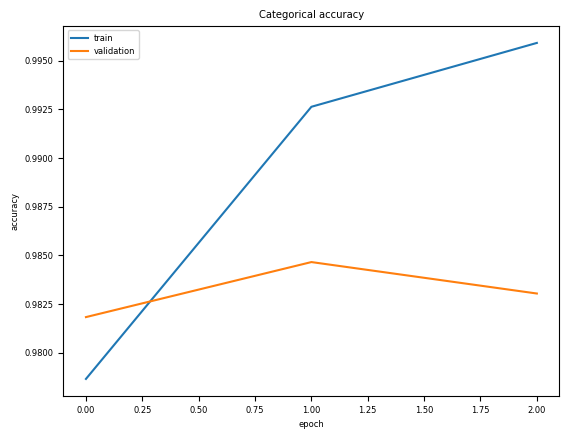

In [97]:
def plot_hist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

Для оценки качества модели построим матрицу ошибок:

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


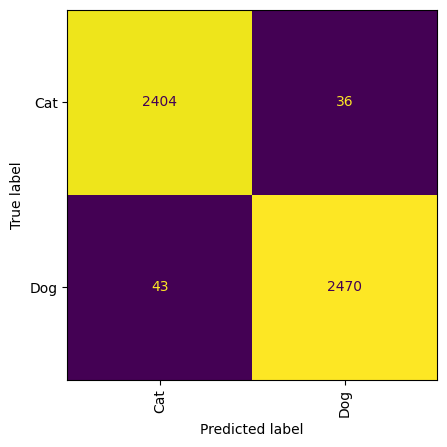

In [99]:
import numpy as np 
from sklearn.metrics import ConfusionMatrixDisplay
y_pred, y_true = [], []
for x,y in val_ds:
    z = model.predict(x,verbose=False).astype(int)
    y_pred.extend(z)
    y_true.extend(y)

plt.rc('font',size=10)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,
                                        display_labels=classes,
                                        xticks_rotation='vertical',
                                        colorbar=False)

Мы добились неплохой точности модели! Для улучшения качества модели можно:
* Использовать аугментацию данных в процессе обучения 
* Попробовать различные базовые модели и другие гиперпараметры (число слоёв полносвязного классификатора и т.д.)

## Сохраняем модель в DataSphere

Мы можем сохранить модель в DataSphere для дальнейшего использования или развёртывания. Для этого:
* Нажмите на вертикальной панели справа значок "поделиться"
* Выберите имя переменной модели, которую хотите сохранить - в нашем случае, `model`
* Укажите имя модели

Такую модель затем можно загрузить в любой ноутбук для дальнейшего использования, использовать для развёртывания веб-сервиса модели, а также поделиться моделью с другими участниками сообщества.
